# 220514 figure 4 draft

In [1]:
from pathlib import Path
from types import SimpleNamespace

In [2]:
import pandas as pd
import numpy as np
import h5py as h5
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from gambit.db import Taxon, load_genomeset

In [4]:
%matplotlib inline

## Setup

In [5]:
DATESTR = '220514'
NBNAME = DATESTR + '-figure-4-draft'

In [6]:
wf_tmp_dir = Path('/home/jared/code/gambit/gambit-publication/intermediate-data/db-pw-dists')

infiles = dict(
    genomes='/home/jared/projects/gambit/data/databases/refseq-curated/1.0-beta2/gambit-genomes-1.0b2-211111.db',
    # chunks_summary=wf_tmp_dir / 'chunks.csv',
    chunk_taxa=wf_tmp_dir / 'chunk-taxa.csv',
    chunk_genomes_dir=wf_tmp_dir / 'chunks',
    dists_dir=wf_tmp_dir / 'dists',
    overlaps='data-processed/220507-db-pw-dists/220507-db-overlaps.csv',
    dists_summary='data-processed/220507-db-pw-dists/220507-db-dists-summary.csv',
)

In [7]:
processed_out = Path('data-processed/') / NBNAME
processed_out.mkdir(exist_ok=True)

In [8]:
plot_tids = [801, 869]

## Code

In [9]:
def fix_nullable_int_col(df, col):
    """Fix column containing ints/Nones after Pandas coerces it to float data type."""
    df[col] = np.asarray([None if pd.isnull(v) else int(v) for v in df[col]], dtype=object)

## Load data

### Database

In [10]:
session, gset = load_genomeset(infiles['genomes'])

In [11]:
taxa_by_id = {t.id: t for t in gset.taxa}

### Distance matrix chunks

In [12]:
chunk_taxa = pd.read_csv(infiles['chunk_taxa'], index_col=0)
fix_nullable_int_col(chunk_taxa, 'ncbi_id')

nchunks = chunk_taxa['chunk'].max() + 1

In [13]:
chunk_genomes = pd.concat(
    [
        pd.read_csv(infiles['chunk_genomes_dir'] / f'{i}.csv', index_col=0)
        for i in range(nchunks)
    ],
    keys=range(nchunks),
    names=['chunk'],
)

In [14]:
chunk_pairs = [(i, j) for i in range(nchunks) for j in range(i, nchunks)]

In [15]:
dmat_files = {(i, j): infiles['dists_dir'] / f'{i}-{j}.h5' for i, j in chunk_pairs}

### Last notebook

In [16]:
dists_df = pd.read_csv(infiles['dists_summary'], index_col=0)
dists_df.index.name = 'taxon_id'

In [17]:
overlaps_df = pd.read_csv(infiles['overlaps'], index_col=[0, 1])

## More code

In [18]:
def _get_taxon(t):
    return t if isinstance(t, Taxon) else taxa_by_id[t]

def get_taxon_chunk(taxon):
    return chunk_taxa.loc[_get_taxon(taxon).root().id, 'chunk']

def get_genome_indices_direct(chunk, tids, asint=True):
    bools = np.in1d(chunk_genomes.loc[chunk, 'taxon_id'], tids)
    return np.flatnonzero(bools) if asint else bools

def get_genome_indices_subtree(chunk, taxon, asint=True):
    subtree_tids = [t.id for t in taxon.traverse()]
    return get_genome_indices_direct(chunk, subtree_tids, asint)


def load_matrix_subset(dataset, rows, cols):
    assert dataset.ndim == 2
    rows = np.asarray(rows)
    cols = np.asarray(cols)
    assert rows.ndim == 1
    assert cols.ndim == 1
    
    if rows.dtype.kind == 'b':
        rows = np.flatnonzero(rows)
    elif rows.dtype.kind not in 'ui':
        raise ValueError('Rows dtype')
        
    if cols.dtype.kind == 'b':
        ncol = cols.sum()
    elif cols.dtype.kind in 'ui':
        ncol = len(cols)
    else:
        raise ValueError('Cols dtype')
        
    out = np.empty((len(rows), ncol), dtype=dataset.dtype)
    for i, r in enumerate(rows):
        out[i, :] = dataset[r, cols]
        
    return out


def load_matrix_triu(dataset, indices):
    assert dataset.ndim == 2
    assert indices.ndim == 1
    assert indices.dtype.kind in 'ui'
    n = len(indices)
    npairs = n * (n - 1) // 2
    
    out = np.empty(npairs, dtype=dataset.dtype)
    
    start = 0
    for i, ix in enumerate(indices):
        l = n - i - 1
        out[start:start + l] = dataset[ix, indices[i+1:]]
        start += l
        
    assert start == npairs
    return out
        

def load_inter_dists(taxon1, taxon2, flat=False):
    taxon1 = _get_taxon(taxon1)
    taxon2 = _get_taxon(taxon2)
    chunk1 = get_taxon_chunk(taxon1)
    chunk2 = get_taxon_chunk(taxon2)
    
    if chunk1 > chunk2:
        taxon1, taxon2 = taxon2, taxon1
        chunk1, chunk2 = chunk2, chunk1
        flipped = True
    else:
        flipped = False
        
    indices1 = get_genome_indices_subtree(chunk1, taxon1)
    indices2 = get_genome_indices_subtree(chunk2, taxon2)
    
    with h5.File(dmat_files[chunk1, chunk2]) as file:
        dmat = file['dmat']
        dists = load_matrix_subset(dmat, indices1, indices2)
        
        if flat:
            return dists.flatten()
        return dists.t if flipped else dists
    

def load_intra_dists(taxon):
    taxon = _get_taxon(taxon)
    chunk = get_taxon_chunk(taxon)
    indices = get_genome_indices_subtree(chunk, taxon)
    
    with h5.File(dmat_files[chunk, chunk]) as file:
        dmat = file['dmat']
        return load_matrix_triu(dmat, indices)

## Calculations

In [19]:
plot_data = []

for tid in tqdm(plot_tids):
    taxon = taxa_by_id[tid]
    
    data = SimpleNamespace(taxon=taxon)
    plot_data.append(data)

    data.subtree_tids = [leaf.id for leaf in taxon.traverse()]
    data.taxon_chunk = get_taxon_chunk(taxon)

    # Genome indices
    genome_chunk_indices_bool = chunk_genomes.loc[data.taxon_chunk, 'taxon_id'].isin(data.subtree_tids)
    genome_chunk_indices = np.flatnonzero(genome_chunk_indices_bool)
    data.subtree_gids = genome_chunk_indices_bool.index[genome_chunk_indices_bool]
    ngenomes = len(genome_chunk_indices)

    # Find minimum distances
    data.min_inter_dist = np.full(ngenomes, np.inf, dtype=np.float32)
    data.min_inter_gid = np.full(ngenomes, -1, dtype=int)
    data.min_inter_tid = np.full(ngenomes, -1, dtype=int)

    data.closest_dist = np.full(ngenomes, np.inf, dtype=np.float32)
    data.closest_gid = np.full(ngenomes, -1, dtype=int)
    data.closest_tid = np.full(ngenomes, -1, dtype=int)

    for chunk in range(nchunks):
        this_chunk_genomes = chunk_genomes.loc[chunk]

        flipped = chunk < data.taxon_chunk
        pair = (chunk, data.taxon_chunk) if flipped else (data.taxon_chunk, chunk)

        with h5.File(dmat_files[pair]) as file:
            dmat = file['dmat']
            for i, ix in enumerate(genome_chunk_indices):
                row = dmat[:, ix] if flipped else dmat[ix, :]
                inter_row = np.ma.masked_where(genome_chunk_indices_bool, row) if chunk == data.taxon_chunk else row
                other_row = np.ma.masked_where(np.arange(this_chunk_genomes.shape[0]) == ix, row) if chunk == data.taxon_chunk else row

                inter_min_idx = np.argmin(inter_row)
                min_d = row[inter_min_idx]
                if min_d < data.min_inter_dist[i]:
                    data.min_inter_dist[i] = min_d
                    data.min_inter_gid[i] = this_chunk_genomes.index[inter_min_idx]
                    data.min_inter_tid[i] = this_chunk_genomes['taxon_id'].iloc[inter_min_idx]

                min_idx = np.argmin(other_row)
                min_d = row[min_idx]
                if min_d < data.closest_dist[i]:
                    data.closest_dist[i] = min_d
                    data.closest_gid[i] = this_chunk_genomes.index[inter_min_idx]
                    data.closest_tid[i] = this_chunk_genomes['taxon_id'].iloc[inter_min_idx]
                    
    # Inter taxa/distances
    data.out_taxa = [taxa_by_id[tid] for tid in set(data.min_inter_tid)]
    data.inter_dists = [load_inter_dists(taxon, out) for out in data.out_taxa]
    
    # Intra distances
    data.intra_dists = load_intra_dists(taxon)

  0%|          | 0/2 [00:00<?, ?it/s]

## Plot

In [20]:
plt.style.use('default')

plt.rcParams.update({
    'axes.grid': True,
})

In [21]:
palette = sns.color_palette('Set1')

In [22]:
def histogram(ax, x, **kw):
    sns.histplot(x, ax=ax, element='step', **kw)

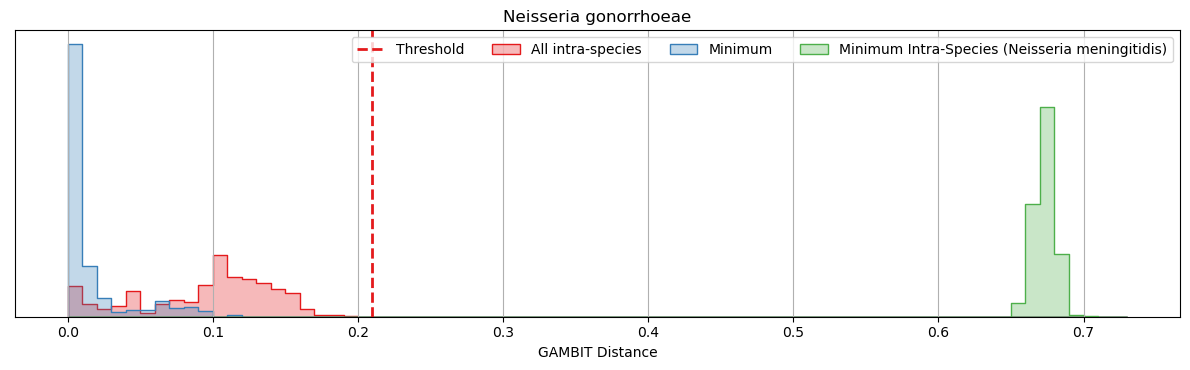

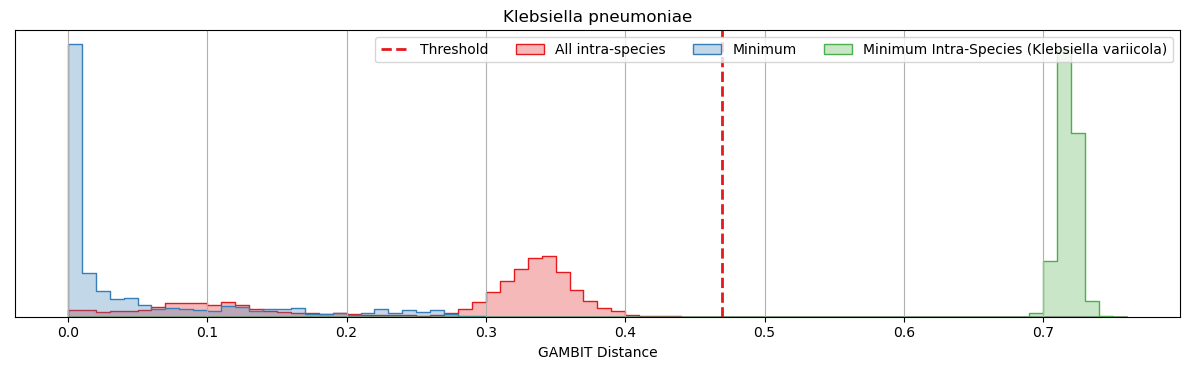

In [23]:
for data in plot_data:
    fig = plt.figure(figsize=(12, 4))
    ax = plt.gca()
    ax.yaxis.set_visible(False)
    
    intra_names = ', '.join(taxa_by_id[tid].name for tid in set(data.min_inter_tid))
    
    values = [data.intra_dists, data.closest_dist, data.inter_dists[0].flatten()]
    labels = ['All intra-species', 'Minimum', f'Minimum Intra-Species ({intra_names})']
    xmax = max(v.max() for v in values)

    for x, label, color in zip(values, labels, palette):
        sns.histplot(
            x=x,
            element='step',
            binrange=(0, xmax),
            binwidth=0.01,
            alpha=.3,
            color=color,
            stat='density',
            label=label,
        )
        
    ax.axvline(
        data.taxon.distance_threshold,
        lw=2,
        linestyle='dashed',
        color=palette[0],
        label='Threshold',
    )
    
    
    ax.set_title(data.taxon.name)
    ax.set_xlabel('GAMBIT Distance')
    plt.tight_layout(rect=(0, 0.05, 1, 1))
    ax.legend(
        ncol=4,
        # loc='lower center',
        loc='upper right',
    )
    
    name = data.taxon.name.replace(' ', '_')
    plt.savefig(processed_out / f'{DATESTR}-fig4-{name}.png')